## Task 1

Build a model to predict likelihood of developing damp and mould in our properties.

In [1]:
import pandas as pd
import numpy as np

tenancy_case_df = pd.read_csv("tenancy_case.csv", parse_dates=["tenancy_start_date", "tenancy_end_date", "case_create_date"])

## Table of contents

- Model formulation
    - Optimum point-in-time
- Target
- Feature Engineering
- Model Development
    - Pipeline
    - Hyperparameter Tuning
- Analysis
    - Model Performance
    - Feature Importance
- Improvement Ideas

## Model Formulation

Given a point-in-time $t$, we are not interested in whether a unit had damp & mould issue in the past, but we would like to know how likely the property will have damp & mould issue in the future.

Therefore, we will build a binary classification model using the following definitions:

- Each example in our training set will be a unit which is occupied at time $t$.
- The target has a value 1 if the unit reports damp & mould issue at least once in the future at some time $t'>t$, and 0 otherwise. 

The reason for this formulation is two-fold:

1. This closely simluates the deployment in real world, where we need to make batch predictions at time $t$ and determine which unit will develop damp & mould issue at some time $t'>t$.
2. This prevents target leakage since we can formally limit ourselves to only engineer features using information up to time $t$.

### Optimum point-in-time

We need to choose a time $t$ such that it has a good balance between the number of issues in the history (for feature engineering) and the number of issues in the future (for a less imbalanced target).

Looking at the graph below, the optimum point seems to be mid-2020, so we set the point-in-time date to 2020-06-01.

<AxesSubplot:xlabel='case_create_date'>

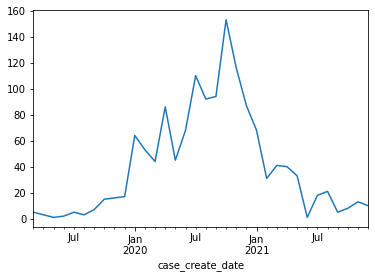

In [2]:
damp_cond = tenancy_case_df["case_sub_type"]=="Damp & Mould"
tenancy_case_df[damp_cond].set_index("case_create_date").resample("M")["unit_ref"].count().plot()

In [3]:
date = "2020-06-01"

## Target

`tenancy_case_df` contains the case history reported by tenants living in the unit on 2020-06-01. Since we are building the model on a unit level, we need to aggregate up to the unit level.

In [4]:
def create_target(tenancy_case_df, date):
    """
    Given a point-in-time, create a column to indicate whether the unit has at least once damp and mould issue in the future. 
    """    
    # create unit damp indicator
    future_cond = tenancy_case_df.case_create_date > date 
    damp_cond = tenancy_case_df["case_sub_type"]=="Damp & Mould"
    tenancy_case_df = tenancy_case_df.assign(damp_ind=np.where(damp_cond & future_cond, 1, 0))
    
    # aggregate up to unit level by summing the total number of damp and mould issues 
    unit_damp_df = tenancy_case_df.groupby("unit_ref")["damp_ind"].sum().rename("number_damp_issue_future").reset_index()
    unit_damp_df = unit_damp_df.assign(target=np.where(unit_damp_df["number_damp_issue_future"]==0, 0, 1))
    
    return unit_damp_df["target"]

In [5]:
target = create_target(tenancy_case_df, date)
target.value_counts()

0    8620
1     940
Name: target, dtype: int64

## Feature Engineering

Using our domain knowledge, we create the following features which might be useful to predict the likelihood of having damp & mould issues.

1. **Tenant**
- `number_vul_tenants`: Number of vulnerable tenants in the unit. 
- `tenancy_length`: Average length of tenancy (days) for the unit. (i.e how long has the current tenant been staying in the unit).

2. **Unit**
- `unit_age`: The building age of the unit (years).
- `number_maintenance`: Number of direct maintenance reported in the past.
- `number_damp_past`: Number of damp & mould issues reported in the past.

In [6]:
def create_number_vul_tenants(tenancy_case_df):    
    tenants_df = tenancy_case_df[["unit_ref", "tenancy_id", "vul_ind"]].drop_duplicates()
    number_vul_tenants = tenants_df.groupby("unit_ref")["vul_ind"].sum().rename("number_vul_tenants")
    
    return number_vul_tenants

In [7]:
number_vul_tenants = create_number_vul_tenants(tenancy_case_df)
number_vul_tenants.value_counts()

0.0    7158
1.0    2399
2.0       3
Name: number_vul_tenants, dtype: int64

In [8]:
def create_tenancy_length(tenancy_case_df, date):    
    tenants_df = tenancy_case_df[["unit_ref", "tenancy_id", "tenancy_start_date"]].drop_duplicates()
    # tenancy length is the number of days between current date and tenancy start date
    tenants_df = tenants_df.assign(tenancy_length=(pd.to_datetime(date)-tenants_df["tenancy_start_date"]).dt.days)
    tenancy_length = tenants_df.groupby("unit_ref")["tenancy_length"].mean().rename("avg_tenancy_length")

    return tenancy_length

In [9]:
tenancy_length = create_tenancy_length(tenancy_case_df, date)
tenancy_length.describe()

count     9560.000000
mean      3862.904132
std       3287.768454
min          0.000000
25%       1267.000000
50%       3129.000000
75%       5534.000000
max      43616.000000
Name: avg_tenancy_length, dtype: float64

In [10]:
def create_unit_age(tenancy_case_df, date):    
    units_df = tenancy_case_df[["unit_ref", "unit_build_year"]].drop_duplicates()
    # building age is the number of years between current year and unit build year
    units_df = units_df.assign(unit_age=pd.to_datetime(date).year-units_df["unit_build_year"])
    
    return units_df.set_index("unit_ref").unit_age

In [11]:
unit_age = create_unit_age(tenancy_case_df, date)
unit_age.describe()

count    9135.000000
mean       45.401642
std        43.954170
min         0.000000
25%        12.000000
50%        26.000000
75%        67.000000
max       300.000000
Name: unit_age, dtype: float64

In [12]:
def create_number_maintenance(tenancy_case_df, date):    
    # create unit maintenance indicator
    past_cond = tenancy_case_df.case_create_date < date 
    maintenance_cond = tenancy_case_df["case_type"]=="Direct Maintenance"
    tenancy_case_df = tenancy_case_df.assign(maintenance_ind=np.where(past_cond & maintenance_cond, 1, 0))
    
    number_maintenance = tenancy_case_df.groupby("unit_ref")["maintenance_ind"].sum().rename("number_maintenance")
    
    return number_maintenance

In [13]:
number_maintenance = create_number_maintenance(tenancy_case_df, date)
number_maintenance.value_counts()

0    7833
1    1371
2     263
3      63
4      25
5       3
7       2
Name: number_maintenance, dtype: int64

In [14]:
def create_number_damp(tenancy_case_df, date):    
    # create unit damp indicator
    past_cond = tenancy_case_df.case_create_date < date 
    damp_cond = tenancy_case_df["case_sub_type"]=="Damp & Mould"
    tenancy_case_df = tenancy_case_df.assign(damp_ind=np.where(past_cond & damp_cond, 1, 0))
    
    number_damp_past = tenancy_case_df.groupby("unit_ref")["damp_ind"].sum().rename("number_damp_past")
    
    return number_damp_past

In [15]:
number_damp_past = create_number_damp(tenancy_case_df, date)
number_damp_past.value_counts()

0    9214
1     327
2      18
3       1
Name: number_damp_past, dtype: int64

In [16]:
feature_df = pd.concat([number_vul_tenants, tenancy_length, unit_age, number_maintenance, number_damp_past], axis=1)

assert len(feature_df) == len(target)

In [17]:
feature_df.head()

,number_vul_tenants,avg_tenancy_length,unit_age,number_maintenance,number_damp_past
unit_ref,,,,,
Unit0,0.0,1884.0,110.0,2,1
Unit1,0.0,3199.0,30.0,0,0
Unit10,1.0,6113.0,46.0,0,0
Unit100,0.0,2471.0,23.0,1,0
Unit1000,0.0,4806.0,13.0,0,0


In [18]:
# only the unit_age has missing values
feature_df.isna().sum()

number_vul_tenants      0
avg_tenancy_length      0
unit_age              425
number_maintenance      0
number_damp_past        0
dtype: int64

## Model Development

### Pipeline

Given that we have an imbalanced dataset, we will perform random undersampling to undersample the majority class without replacement.

Since we only have 5 features, we will use a simpler model (Logistic Regression) to fit the data. By using Logistic Regression, the model is also more interpretable because we can get the coefficients associated with each feature and understand how each feature contributes to the prediction.

Since we are using regularization for the model, we will standardize the features by removing the mean and scaling to unit variance. We also impute the missing values (only for unit age in the given data) with the average value since that's our "best guess" if we have no information about the unit age.

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feature_df, target, test_size=0.2, random_state=0, stratify=target)

In [20]:
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(
    StandardScaler(), 
    SimpleImputer(strategy="mean"),
    RandomUnderSampler(random_state=0),
    LogisticRegression(random_state=0),
)

### Hyperparameter Tuning
We split the data into 80% train and 20% test set, and perform random search on the 80% train set using 3-fold cross-validation.

As for the metrics, we will use f1 score to detertmine the best model during hyperparameter tuning.

In [21]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform

param_distributions = {
    'logisticregression__penalty' : ['l1', 'l2'],
    'logisticregression__C' : loguniform(1,100),
    'logisticregression__solver' : ['liblinear', 'saga'] # only these two solvers can handle l1 and l2 penalty
}

clf = RandomizedSearchCV(pipe, param_distributions, cv=3, scoring=["precision", "recall", "f1"], return_train_score=True, 
                         refit="f1", random_state=0)

search = clf.fit(X_train, y_train)

In [22]:
from pprint import pprint

print(f"Best hyperparameters:") 
pprint(search.best_params_) 
print(f"Best f1 score: {search.best_score_:.2f}")

Best hyperparameters:
{'logisticregression__C': 7.501954443620119,
 'logisticregression__penalty': 'l1',
 'logisticregression__solver': 'liblinear'}
Best f1 score: 0.24


## Analysis 

### Model Performance

*Assumption: After we identify the potential units with high likelihood of having damp & mould issue, we will send a maintenance team to check whether these units do have a damp & mould issue.*

Using only 5 features, our model achieves 15% precision and 61% recall. This means for every 100 units which the model predicts to have damp & mould issue, only 15 of these units actually have damp & mould issue. While this is not ideal, a false positive is a relatively small cost to the business since the maintenance check is only a small inconvenience to the tenants.

On the other hand, our model can identify 61% of all units which have damp & mould issue. This is more important since failing to identify a unit which has damp and mould issue will result in bad tenant experience and reputational damage. 

By default, Logistic Regression uses a threshold of 50% to classify whether a unit has damp & mould issue. If we have an estimate of the cost for false positive and false negative,  we can find the optimum threshold by minimizing the cost.  

In [23]:
from sklearn.metrics import classification_report

y_pred = search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.63      0.75      1724
           1       0.15      0.61      0.25       188

    accuracy                           0.63      1912
   macro avg       0.55      0.62      0.50      1912
weighted avg       0.86      0.63      0.70      1912



### Feature Importance

We observe that the `unit_age` is the most important feature in predicting the likelihood of damp & mould problem, despite being the only feature with missing values. Therefore, we should prioritize in getting the unit age information. Currently, our pipeline is extracting the unit age information from the case history so the units which have yet to raise any case will not have unit age information. One potential solution is to extract the unit age information from units dataset (if available).

The second most important feature is the number of tenants with vulnerability, which aligns with the result of hypothesis testing in part 2. 

In [24]:
pd.Series(search.best_estimator_['logisticregression'].coef_.ravel(), index=X_train.columns).sort_values(ascending=False)

unit_age              0.328440
number_vul_tenants    0.262551
number_damp_past      0.134899
number_maintenance    0.129857
avg_tenancy_length    0.034351
dtype: float64

## Improvement Ideas

We could enginner the following features if we have more information about the unit.
- Geographic location: Perhaps units in locations with high humidity might be more prone to damp & mould issue.
- Mapping between units and flats: If a unit in the flat has damp & mould issue, other units in the same flat might have the same issue.